<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "3C"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/3C/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


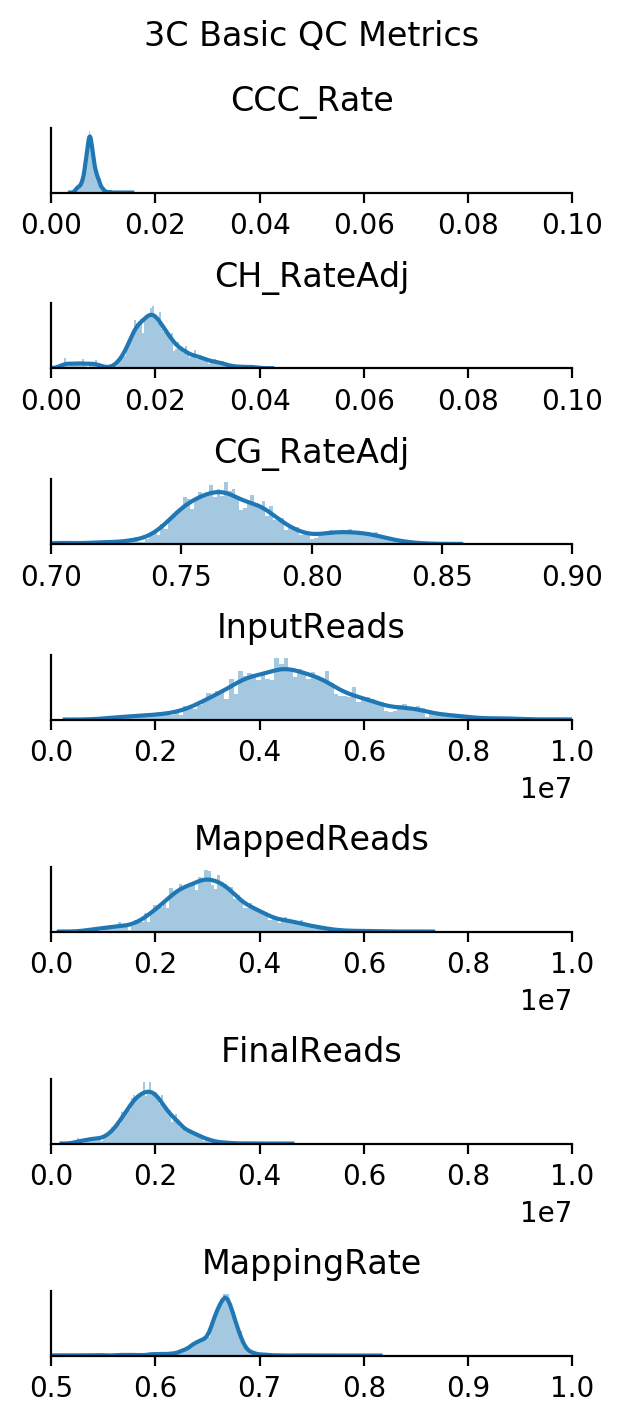

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

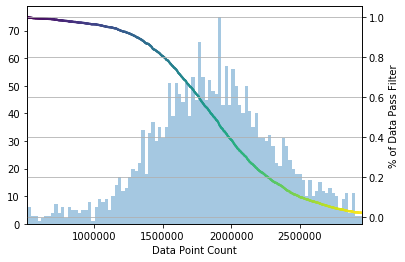

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2387/2387 (100.0%)
CG_RateAdj passed 2387/2387 (100.0%)
CH_RateAdj passed 2387/2387 (100.0%)
FinalReads passed 2387/2387 (100.0%)
MappingRate passed 2387/2387 (100.0%)
Overall passed 2387/2387 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 1161
171207 1226


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 281 73.2%
ad002 270 70.3%
ad004 287 74.7%
ad006 291 75.8%
ad007 305 79.4%
ad008 324 84.4%
ad010 315 82.0%
ad012 314 81.8%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
3C_M_0,/gale/raidix/rdx-4/CEMBA_RS1/3C/CEMBA171206_3C...,0.00738,0.75953,0.75774,0.02543,0.01818,1195574.0,2896392,1812485.0,3C,...,0.802609,-13.342801,-3.350035,43.934154,IT-L23 Cux1,-1.206912,8.068015,4.873946,-25.280962,True
3C_M_1,/gale/raidix/rdx-4/CEMBA_RS1/3C/CEMBA171206_3C...,0.00938,0.77904,0.77695,0.03741,0.02830,1355517.0,3306366,2086717.0,3C,...,11.820558,-13.036840,21.342982,23.994011,IT-L5 Etv1,6.679052,4.603506,-14.968661,3.478202,True
3C_M_10,/gale/raidix/rdx-4/CEMBA_RS1/3C/CEMBA171206_3C...,0.00915,0.82430,0.82268,0.03678,0.02789,2815807.0,7382298,4854305.0,3C,...,22.803186,15.048880,27.868423,51.776826,L6b Adcy8,15.311126,5.588922,-9.416371,-0.754781,True
3C_M_100,/gale/raidix/rdx-4/CEMBA_RS1/3C/CEMBA171206_3C...,0.00978,0.79705,0.79505,0.04231,0.03285,2392650.0,5865154,3939036.0,3C,...,-24.612488,5.025195,8.516938,-42.884495,MGE-Pvalb Sema5a,-3.787118,-9.053948,13.797423,18.999188,True
3C_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/3C/CEMBA171206_3C...,0.00776,0.78781,0.78615,0.02789,0.02029,1922013.0,4800236,3102319.0,3C,...,14.241365,-4.720473,7.510418,-14.813346,IT-L6 Man1c1,-9.653825,-6.081754,3.554543,-15.530345,True
3C_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/3C/CEMBA171206_3C...,0.00837,0.84538,0.84407,0.03721,0.02908,1834302.0,4663316,2941338.0,3C,...,22.666603,14.720142,27.103599,48.994541,L6b Adcy8,17.030863,3.437392,-9.856043,4.707852,True
3C_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/3C/CEMBA171206_3C...,0.00817,0.75618,0.75417,0.02505,0.01702,1484625.0,3828116,2470100.0,3C,...,1.929142,-15.342752,-34.266103,16.266165,IT-L23 Cux1,-3.134690,10.594099,-6.957810,-39.741965,True
3C_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/3C/CEMBA171206_3C...,0.00740,0.78035,0.77871,0.02429,0.01702,1771452.0,4764232,2951780.0,3C,...,20.124336,8.309930,-41.648006,-25.579086,CT-L6 Il1rap,-6.404701,-14.638034,33.248298,11.003781,True
3C_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/3C/CEMBA171206_3C...,0.00729,0.78263,0.78103,0.02559,0.01843,1593072.0,4096768,2649482.0,3C,...,20.028378,8.093341,-41.691903,-25.161761,CT-L6 Il1rap,-6.518951,-15.201039,34.993390,8.949348,True
3C_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/3C/CEMBA171206_3C...,0.00837,0.76114,0.75912,0.03101,0.02283,1345810.0,3459190,2279701.0,3C,...,9.549325,-13.805438,13.362750,27.087470,IT-L5 Cdh8,5.195347,9.493073,-9.086676,-19.481054,True
